[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AI-HPC-Research-Team/AI-Basics/blob/main/03%20Supervised%20Learning/linear_regression_from_scratch.ipynb)
### Linear regression from scratch

In this seminar you will implement a linear regression and train it using just the (stochastic) gradient descent, numpy and your brain.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

**Acknowledgements**: I've primariliy used the material from [Andrew Ng's Coursera course][1] for this, but have also been helped by [this article][2] and [this one][3]. I used some code for the animation from [this kernel][4].

  [1]: https://www.coursera.org/learn/machine-learning
  [2]: http://tillbergmann.com/blog/python-gradient-descent.html
  [3]: http://aimotion.blogspot.co.uk/2011/10/machine-learning-with-python-linear.html
  [4]: https://www.kaggle.com/ronaldtroncoso20/d/START-UMD/gtd/global-terrorism-trends-animation

Load the libraries and data...

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import http
import io
import requests

url = 'https://github.com/AI-HPC-Research-Team/AI-Basics/raw/refs/heads/main/03%20Supervised%20Learning/data/house-train.csv'
try:
    data = pd.read_csv(url)
except http.client.IncompleteRead as e:
    r = requests.get(url, timeout=10)
    b = io.StringIO(r.text)
    data = pd.read_csv(b)

Inspect the data

In [ ]:
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


### Univariate linear regression using an analytic solution

In this section, you will program the univariate least squares linear regression from scratch using an analytic formulae.

Recall, that we're working with a problem of finding a weight $w$ such that
$$
\sum_i (y_i - w \cdot x_i)^2 \to \min,
$$
with $x_i, y_i \in R^1$, i.e. they are numbers.

Recall that our least squares solution is of the form:
$$
\widehat{w}_1 =
    \frac{\sum_{i=1}^{\ell} (x_i - \mu_x) (y_i - \mu_y)}
        {\sum_{i=1}^{\ell} (x_i - \mu_x)^2}, \\
\widehat{w}_0 = \mu_y - \widehat{w}_1 \mu_x
$$
with $\mu_x = \frac{1}{\ell} \sum_{i=1}^{\ell} x_i,
\quad
\mu_y = \frac{1}{\ell} \sum_{i=1}^{\ell} y_i$

Hints: use `np.mean` to compute the mean.

In [ ]:
def compute_weights_univariate(X, y):
    """
    Given feature array X [n_samples], target vector y [n_samples],
    compute the optimal least squares solution using the formulae above.
    """
    X = np.asarray(X).ravel()
    y = np.asarray(y).ravel()
    mu_x = X.mean()
    mu_y = y.mean()
    num = np.sum((X - mu_x) * (y - mu_y))
    den = np.sum((X - mu_x) ** 2)
    w1 = num / den
    w0 = mu_y - w1 * mu_x
    return np.array([w0, w1])

In [ ]:
X = data['GrLivArea']
y = data['SalePrice']

w = compute_weights_univariate(X, y)
w

array([18569.02585649,   107.13035897])

**How precise are we?**

We commonly evaluate predictions using MSE errors. These are defined as:
$$
MSE(y, \widehat{y}) = \frac 1 \ell \sum_i (y_i - w^T x_i)^2
$$
as implemented either by `sklearn.metrics.mean_squared_error` or simply by `np.mean((y - y_pred) ** 2)`.

We then use $\sqrt{MSE(y, \widehat{y})}$ to obtain numbers in the same dimensionality (units, not units squared).

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
w_0, w_1 = w
np.sqrt(
    mean_squared_error(y, np.dot(X, w_1) + w_0)
)

np.float64(56034.303865279944)

<>:3: SyntaxWarning: invalid escape sequence '\w'
<>:5: SyntaxWarning: invalid escape sequence '\w'
<>:3: SyntaxWarning: invalid escape sequence '\w'
<>:5: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-3366599178.py:3: SyntaxWarning: invalid escape sequence '\w'
  axs[0].set_title('$y$ vs. $\widehat{y} = X \widehat{w}$')
/tmp/ipython-input-3366599178.py:5: SyntaxWarning: invalid escape sequence '\w'
  axs[1].set_title('Error $y - X \widehat{w}$')


Text(0.5, 1.0, 'Error $y - X \\widehat{w}$')

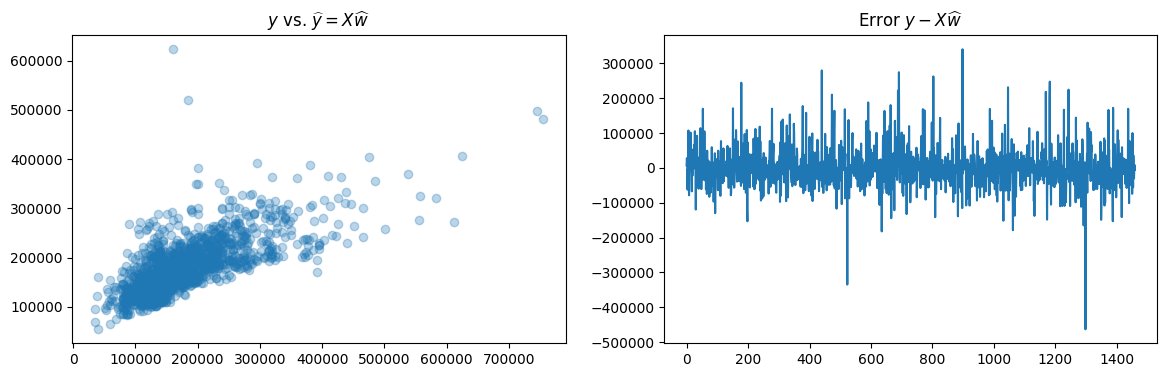

In [ ]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
axs[0].scatter(y, np.dot(X, w_1) + w_0, alpha=.3)
axs[0].set_title('$y$ vs. $\widehat{y} = X \widehat{w}$')
axs[1].plot(y - (np.dot(X, w_1) + w_0))
axs[1].set_title('Error $y - X \widehat{w}$')

### Multivariate linear regression using an analytic solution

In this section, you will program the **multi**variate least squares linear regression from scratch using an analytic formulae.

Recall, that we're working with a problem of finding a weight $w$ such that
$$
||\mathbf{y} - \mathbf{X} \mathbf{w}|| \to \min_{\mathbf{w}},
$$
with $\mathbf{x}_i \in R^n$, i.e. features are no longer supposed to be single numbers, but vectors of numbers (but still $y_i \in R^1$).

Recall that our least squares solution is of the form:
$$
\mathbf{w} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}.
$$

We could account for the non-zero mean case ($\mathrm{E} \mathbf{y} \neq 0$) by either adding and subtracting the mean, or by using an additional feature in $\mathbf{X}$ set to all ones.

Hint: matrix inverse is computed by `np.linalg.inv`, and matrix-vector product by `np.dot`.

In [ ]:
def prepare_features(X):
    """
    Given feature array X [n_samples, n_features], preprocess it by
    standardizing and appending a column of 1s.
    """
    # First, standardize the input by subtracting mean and dividing by std
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    # Append a free term (a column of 1s)
    X = np.c_[np.ones(X.shape[0]), X]
    return X

In [ ]:
def compute_weights_multivariate(X, y):
    """
    Given feature array X [n_samples, 1], target vector y [n_samples],
    compute the optimal least squares solution using the formulae above.
    Don't forget the bias term!
    """
    X = np.asarray(X)
    y = np.asarray(y).ravel()
    Xp = prepare_features(X)                       # 标准化 + 追加常数列
    XtX = Xp.T @ Xp
    Xty = Xp.T @ y
    w = np.linalg.inv(XtX) @ Xty                   # (X^T X)^(-1) X^T y
    return w

In [ ]:
X = data['GrLivArea']
X = np.atleast_2d(X).T
y = data['SalePrice']

w = compute_weights_multivariate(X, y)
w

array([180921.19589041,  56275.61972722])

In [ ]:
# note that we must run prepare_features(X) here, too, to obtain the exact same
# feature representation of the input
np.sqrt(
    mean_squared_error(y, np.dot(prepare_features(X), w))
)

np.float64(56034.303865279944)

Now that you have implemented the weight computation procedure, you can test it using our dataset, using
* different features (or even their subsets!),
* different sub-samples of $x_i$s and $y_i$s.

In [ ]:
columns = [
    'LotFrontage',
    'LotArea',
    'MoSold',
    'YrSold',
    'OverallQual',
    'OverallCond',
    'YearBuilt',
    'YearRemodAdd',
    'MasVnrArea',
    'BsmtFinSF1',
    'GrLivArea'
]

In [ ]:
for col in columns:
    X = data[col]
    X = np.atleast_2d(X).T
    y = data['SalePrice']

    # remove non-filled rows
    isnan_mask = np.any(np.isnan(X), axis=1) | np.isnan(y)
    X = X[~isnan_mask]
    y = y[~isnan_mask]

    w = compute_weights_multivariate(X, y)

    # note that we must construct the same feature vector to compute predictions
    # i.e. standardize and append column of 1s
    X = prepare_features(X)
    print('RMS error when using a single column "{col}" as regressor is {error:.2f}'
        .format(
            col=col,
            error=np.sqrt(mean_squared_error(y, np.dot(X, w)))
        )
    )

RMS error when using a single column "LotFrontage" as regressor is 78026.38
RMS error when using a single column "LotArea" as regressor is 76601.25
RMS error when using a single column "MoSold" as regressor is 79329.64
RMS error when using a single column "YrSold" as regressor is 79382.07
RMS error when using a single column "OverallQual" as regressor is 48589.45
RMS error when using a single column "OverallCond" as regressor is 79174.24
RMS error when using a single column "YearBuilt" as regressor is 67693.25
RMS error when using a single column "YearRemodAdd" as regressor is 68446.98
RMS error when using a single column "MasVnrArea" as regressor is 69639.10
RMS error when using a single column "BsmtFinSF1" as regressor is 73246.55
RMS error when using a single column "GrLivArea" as regressor is 56034.30


We could now easily combine multiple features for regression

In [ ]:
from itertools import combinations

In [ ]:
for cols in combinations(columns, 2):
    X = data[list(cols)]
#     X = np.atleast_2d(X).T
    y = data['SalePrice']

    # remove non-filled rows
    isnan_mask = np.any(np.isnan(X), axis=1) | np.isnan(y)
    X = X[~isnan_mask]
    y = y[~isnan_mask]

    w = compute_weights_multivariate(X, y)

    # note that we must construct the same feature vector to compute predictions
    # i.e. standardize and append column of 1s
    X = prepare_features(X)
    print('RMS error when using a columns "{col}" as regressor is {error:.2f}'
        .format(
            col=cols,
            error=np.sqrt(mean_squared_error(y, np.dot(X, w)))
        )
    )

RMS error when using a columns "('LotFrontage', 'LotArea')" as regressor is 76594.08
RMS error when using a columns "('LotFrontage', 'MoSold')" as regressor is 77921.65
RMS error when using a columns "('LotFrontage', 'YrSold')" as regressor is 78002.37
RMS error when using a columns "('LotFrontage', 'OverallQual')" as regressor is 48053.42
RMS error when using a columns "('LotFrontage', 'OverallCond')" as regressor is 77649.46
RMS error when using a columns "('LotFrontage', 'YearBuilt')" as regressor is 65998.09
RMS error when using a columns "('LotFrontage', 'YearRemodAdd')" as regressor is 66474.78
RMS error when using a columns "('LotFrontage', 'MasVnrArea')" as regressor is 68845.36
RMS error when using a columns "('LotFrontage', 'BsmtFinSF1')" as regressor is 73012.58
RMS error when using a columns "('LotFrontage', 'GrLivArea')" as regressor is 58906.67
RMS error when using a columns "('LotArea', 'MoSold')" as regressor is 76513.66
RMS error when using a columns "('LotArea', 'YrSo

### Multivariante linear regression using the Gradient Descent

To use the gradient descent, we must
* initialize the weights $\mathbf{w}$ somehow,
* find a way of computing the __gradient__ of our quality measure $L(\mathbf{y}, \widehat{\mathbf{y}})$ w.r.t. $\mathbf{w}$,
* starting from the initialization, iteratively update weights using the gradient descent:
$$
\mathbf{w}^{(i+1)} \leftarrow \mathbf{w}^{(i)} - \gamma \nabla_{\mathbf{w}} L
$$

Since we choose $L(\mathbf{y}, \widehat{\mathbf{y}}) \equiv \frac 1 \ell ||\mathbf{y} - \mathbf{X} \mathbf{w} ||^2$, our gradient is $ \frac 2 \ell (\mathbf{y} - \mathbf{X} \mathbf{w}) \mathbf{X} $

In [ ]:
def compute_gradient(X, y, w):
    """
    Computes the gradient of MSE loss
    for multivariate linear regression of X onto y
    w.r.t. w, evaluated at the current w.
    """
    X = np.asarray(X)
    y = np.asarray(y).ravel()
    y_hat = X @ w
    grad = (2.0 / X.shape[0]) * (X.T @ (y_hat - y))   # ∇ = (2/ℓ) X^T (Xw - y)
    return grad

In [ ]:
def gradient_descent(X, y, w_init, iterations=1, gamma=0.01):
    """
    Performs the required number of iterations of gradient descent.
    Parameters:
        X [n_objects, n_features]: matrix of featues
        y [n_objects]: responce (dependent) variable
        w_init: the value of w used as an initializer
        iterations: number of steps for gradient descent to compute
        gamma: learning rate (gradient multiplier)
    """
    costs, ws = [], []
    w = w_init
    for i in range(iterations):
        # Compute our cost in current point (before the gradient step)
        costs.append(mean_squared_error(y, np.dot(X, w)) / len(y))

        # Remember our weights w in current point
        ws.append(w)

        # Compute gradient for w
        w_grad = compute_gradient(X, y, w)

        # Update the current weight w using the formula above (see comments)
        w = w - gamma * w_grad

    return costs, ws

How run the gradient descent to find the optimal weights vector.

In [ ]:
X = data['GrLivArea']
X = np.atleast_2d(X).T
X = prepare_features(X)
y = data['SalePrice']

gamma = 0.01  # Step size
iterations = 200  # No. of iterations
np.random.seed(123)  # Set the seed
w_init = np.random.rand(X.shape[1]) #Pick some random values to start with

# Pass the relevant variables to the function and get the new values back...
costs, ws = gradient_descent(X, y, w_init, iterations, gamma)
w = ws[-1]

# Print the results...
print("Gradient Descent: {:.2f}, {:.2f}".format(w[0], w[1]))

Gradient Descent: 177674.24, 55265.65


The following 3 code cells display the cost function and its progress as the learning continues.

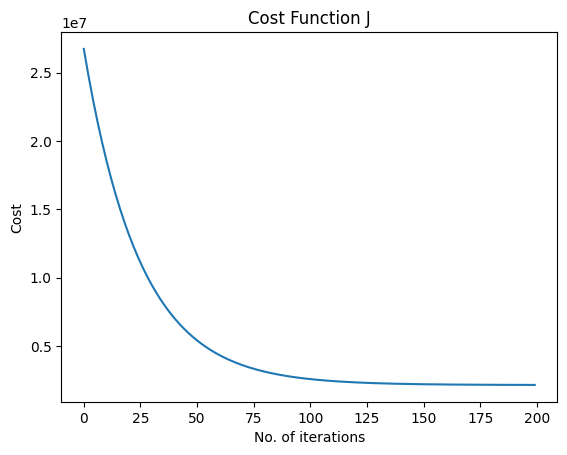

In [ ]:
#Plot the cost function...
plt.title('Cost Function J')
plt.xlabel('No. of iterations')
plt.ylabel('Cost')
plt.plot(costs)
plt.show()

In [ ]:
#Animation
def animate_to_gif(X, y, costs, out_filename='animation.gif'):

    fig = plt.figure()
    ax = plt.axes()
    plt.title('Sale Price vs Living Area')
    plt.xlabel('Living Area in square feet (normalised)')
    plt.ylabel('Sale Price ($)')
    plt.scatter(X[:,1], y, color='red')
    line, = ax.plot([], [], lw=2)
    annotation = ax.text(-1, 700000, '')
    annotation.set_animated(True)
    plt.close()

    #Generate the animation data,
    def init():
        line.set_data([], [])
        annotation.set_text('')
        return line, annotation

    # animation function.  This is called sequentially
    def animate(i):
        x = np.linspace(-5, 20, 1000)
        y = ws[i][1]*x + ws[i][0]
        line.set_data(x, y)
        annotation.set_text('Cost = %.2f e10' % (costs[i]/10000000000))
        return line, annotation

    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=iterations, interval=0, blit=True)

    anim.save(out_filename, writer='pillow', fps = 30)


def animation_display(filename='animation.gif'):
    #Display the animation...
    import io
    import base64
    from IPython.display import HTML

    video = io.open(filename, 'r+b').read()
    encoded = base64.b64encode(video)
    HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))


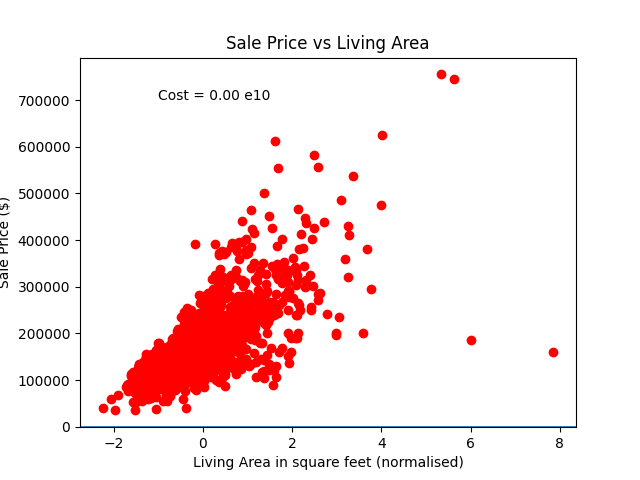

In [ ]:
out_filename = 'animation_gd.gif'

animate_to_gif(X, y, costs, out_filename)

#Display the animation...
import io
import base64
from IPython.display import HTML

video = io.open(out_filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

In [ ]:
### Multivariante linear regression using the Stochastic Gradient Descent

In Stochastic Gradient Descent (SGD), we must do the same as for vanilla GD
* initialize the weights $\mathbf{w}$ somehow,
* find a way of computing the __gradient__ of our quality measure $L(\mathbf{y}, \widehat{\mathbf{y}})$ w.r.t. $\mathbf{w}$,
* starting from the initialization, iteratively update weights using the gradient descent:
$$
\mathbf{w}^{(i+1)} \leftarrow \mathbf{w}^{(i)} - \gamma \nabla_{\mathbf{w}} L
$$
**but** we now compute the gradient with respect to __a single sample__ $(\mathbf{x}_i, y_i)$ only.

Thus, since we choose $L(y_i, \widehat{y}_i) \equiv (y_i - \mathbf{x}_i^T \mathbf{w} )^2$,
our gradient is $ 2 (y_i - \mathbf{x}_i^T \mathbf{w}) \mathbf{x}_i $.

In fact, we can still use the already implemented `compute_gradient` function, but now we should only pass inside the subset (one) input vector.

In [ ]:
def stochastic_gradient_descent(X, y, w_init, iterations=1, gamma=0.01):
    """
    Performs the required number of iterations of stochastic gradient descent.
    Parameters:
        X [n_objects, n_features]: matrix of featues
        y [n_objects]: responce (dependent) variable
        w_init: the value of w used as an initializer
        iterations: number of steps for gradient descent to compute
        gamma: learning rate (gradient multiplier)
    """
    costs, ws = [], []
    w = w_init
    for i in range(iterations):
        # Compute our cost in current point (before the gradient step)
        costs.append(mean_squared_error(y, np.dot(X, w)) / len(y))

        # Remember our weights w in current point
        ws.append(w)

        # Select a random sample from the dataset
        i = np.random.randint(0, X.shape[0])

        # Compute gradient for w  (用 1 个样本近似梯度)
        w_grad = compute_gradient(X[i:i+1], y[i:i+1], w)

        # Update the current weight w using the formula above (see comments)
        w = w - gamma * w_grad

    return costs, ws

In [ ]:
X = data['GrLivArea']
X = np.atleast_2d(X).T
X = prepare_features(X)
y = data['SalePrice']

gamma = 0.01  # Step size
iterations = 200  # No. of iterations
np.random.seed(123)  # Set the seed
w_init = np.random.rand(X.shape[1]) #Pick some random values to start with

# Pass the relevant variables to the function and get the new values back...
costs, ws = stochastic_gradient_descent(X, y, w_init, iterations, gamma)
w = ws[-1]

# Print the results...
print("Gradient Descent: {:.2f}, {:.2f}".format(w[0], w[1]))

Gradient Descent: 172364.64, 49446.91


Note that the cost function is not as smooth anymore

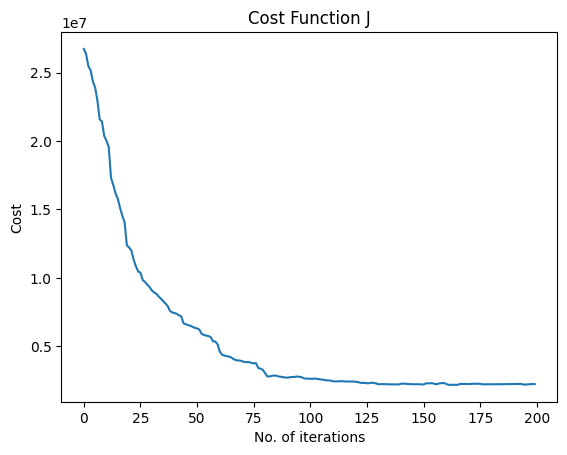

In [ ]:
#Plot the cost function...
plt.title('Cost Function J')
plt.xlabel('No. of iterations')
plt.ylabel('Cost')
plt.plot(costs)
plt.show()

Also note how, along with training, the line estimate is more noisy.


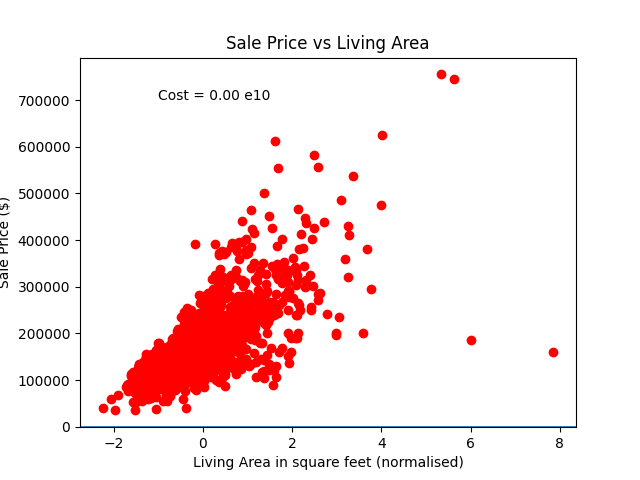

In [ ]:
out_filename = 'animation_sgd.gif'

animate_to_gif(X, y, costs, out_filename)

#Display the animation...
import io
import base64
from IPython.display import HTML

video = io.open(out_filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

### Train / Validation split

We commonly set aside a portion of data for testing our model. In typical scenarios, this corresponds to n-fold cross-validation, but here for the sake of simplicity we only show the train/test split.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = data[columns]
y = data['SalePrice']

# this is common as many columns tend to be empty for some reason
isnan_mask = np.any(np.isnan(X), axis=1) | np.isnan(y)
X = X[~isnan_mask].values
y = y[~isnan_mask].values
# X = prepare_features(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
w = compute_weights_multivariate(X_train, y_train)
w

array([178518.57      ,    977.20602702,   4580.06667258,    665.2280238 ,
          622.51374017,  32539.54891093,   2796.43402859,  11806.0259189 ,
         6659.85912742,   7381.89712021,   7136.00063813,  23526.55515589])

In [ ]:
train_rmse = np.sqrt(mean_squared_error(y_train, np.dot(prepare_features(X_train), w)))
test_rmse = np.sqrt(mean_squared_error(y_test, np.dot(prepare_features(X_test), w)))

print('Train error: ', train_rmse)
print('Test error: ', test_rmse)

Train error:  40612.97975342552
Test error:  38569.18692708995


It turns out that for many cases, validation-set MSE will be very different from MSE computed on train test. Regularization could be seen as one of the ways of tuning (additionally penalizing) the model for being _too well_ fitted on training data. Thus, performance on the validation set is more consistent with that on the training set.

### Regularized multivariate regression

The regularized least squares are given by the formula:
$$
\mathbf{w}^* =
  ( \mathbf{X}^{\intercal} \mathbf{X} + \alpha \mathbf{I})^{-1}
  \mathbf{X}^{\intercal} \mathbf{y}
$$

In [ ]:
def compute_weights_multivariate_l2reg(X, y, reg=1e-3):
    """
    Given feature array X [n_samples, 1], target vector y [n_samples],
    compute the optimal least squares solution using the formulae above.
    Don't forget the bias term!
    """
    X = np.asarray(X)
    y = np.asarray(y).ravel()
    Xp = prepare_features(X)
    n_feats = Xp.shape[1]
    I = np.eye(n_feats)
    I[0, 0] = 0.0                    # 常数项不做正则（更常见的做法）
    w = np.linalg.inv(Xp.T @ Xp + reg * I) @ (Xp.T @ y)
    return w

In [ ]:
w_reg = compute_weights_multivariate_l2reg(X_train, y_train, reg=0)

train_rmse = np.sqrt(mean_squared_error(y_train, np.dot(prepare_features(X_train), w_reg)))
test_rmse = np.sqrt(mean_squared_error(y_test, np.dot(prepare_features(X_test), w_reg)))

print('Train error: ', train_rmse)
print('Test error: ', test_rmse)

Train error:  40612.97975342552
Test error:  38569.18692708995


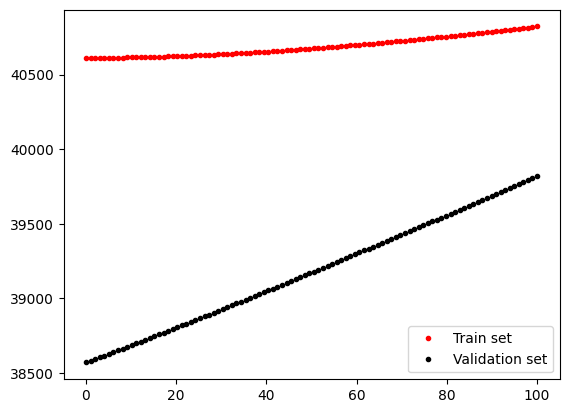

In [ ]:
reg_values = []
train_rmses, test_rmses = [], []
for reg in np.linspace(0.1, 100, 100):
    w_reg = compute_weights_multivariate_l2reg(X_train, y_train, reg=reg)
    reg_values.append(reg)

    train_rmse = np.sqrt(mean_squared_error(y_train, np.dot(prepare_features(X_train), w_reg)))
    test_rmse = np.sqrt(mean_squared_error(y_test, np.dot(prepare_features(X_test), w_reg)))
    train_rmses.append(train_rmse)
    test_rmses.append(test_rmse)

plt.plot(reg_values, train_rmses, 'r.', label='Train set')
plt.plot(reg_values, test_rmses, 'k.', label='Validation set')
plt.legend()

Thus, if we choose $\alpha \approx 50$, we will obtain lower performance on training set, but a more consistent quality estimate for previously unseen instances.

One question that's remaining is -- __how to choose $\alpha$, in practice__?

### Multivariate regression with a prior on weights

Note that the expression for Bayesian regression is the same compared to L2 regression. Yet, it has an important distinction -- the weights prior: $\mathbf{w} \sim \mathcal{N}(0, \Sigma_w)$.

Let $\Sigma_w = \sigma^2_w \mathbf{I}$. If we estimate $\sigma^2_w$ using the training set, we end up having a more principled way of estimating $\mathbf{w}$.

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
y

array([208500, 181500, 223500, ..., 266500, 142125, 147500])

In [ ]:
kfold = KFold(n_splits=10)
ws = []
for train_idx, test_idx in kfold.split(X, y):
    X_train, y_train = X[train_idx], y[train_idx]
    w = compute_weights_multivariate(X_train, y_train)
    ws.append(w)

In [ ]:
np.mean(ws, axis=0), np.std(ws, axis=0)

(array([180443.83445336,   1691.2161652 ,   7045.51506038,   -212.22732196,
          -194.46977993,  32707.10395195,   4356.70599438,  12490.75947858,
          6086.9343304 ,   7444.85093565,  10389.94825912,  26331.56847908]),
 array([ 747.54360013, 1053.04396709,  439.05030707,  866.71489381,
         405.85933893, 1038.72906622,  328.44792848,  378.01591566,
         314.22509011,  744.44680703, 1152.99818831, 1125.23956794]))

In [ ]:
np.mean(np.std(ws, axis=0))

np.float64(716.1928892323789)